# Lib

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchreid.reid.utils import FeatureExtractor

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
from scipy.optimize import linear_sum_assignment

c:\Users\pt101\.conda\envs\myenv\lib\site-packages\torchreid\reid\metrics\rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


## Address def

In [8]:
raw_data_root = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/data'

det_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/detect/inference/txt'
exp_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/'
exp_path_2 = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/selfmodel30'
reid_first_model_ckpt = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/reid/osnet_x1_0_imagenet.pth'
reid_second_model_ckpt = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/model/model30.pth.tar'

gt_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/data/train/'

## Feature Extraction 

In [12]:
data_list = {
        # 'train': ['camera_0001', 'camera_0003', 'camera_0011', 'camera_0013', 'camera_0020', 'camera_0021'],
        'train': ['camera_0003'],    
        'test' : ['camera_0008', 'camera_0019', 'camera_0028'],
        'val'  : ['camera_0005', 'camera_0017', 'camera_0025']
    }


def feature_extraction(data_list, gt_path, raw_data_root, exp_path, reid_model_ckpt):
    W, H = 1920, 1080

    sample_rate = 1 # because we want to test on all frames


    val_transforms = T.Compose([
        T.Resize([256, 128]),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    reid_extractor = FeatureExtractor(
        model_name='osnet_x1_0',
        model_path=reid_model_ckpt,
        image_size=[256, 128],
        device='cuda' 
    )

    for split in ['train']:
        for folder in data_list[split]:

            det_txt_path = os.path.join(gt_path, f'{folder}.txt')
            print(f"Extracting feature from {det_txt_path}")

            dets = np.genfromtxt(det_txt_path, dtype=str,delimiter=',')

            # start extracting frame features
            cur_frame = 0
            emb = np.array([None] * len(dets)) # initialize the feature array

            # for idx, (camera_id, _, frame_id, x, y, w, h, score, _) in enumerate(dets):
            for idx, (camera_id, _, frame_id, x, y, w, h) in enumerate(dets):            
                x, y, w, h = map(float, [x, y, w, h])
                frame_id = str(int(frame_id)) # remove leading space
                
                if idx % 1000 == 0:
                    print(f'Processing frame {frame_id} | {idx}/{len(dets)}')
                
                img_path = os.path.join(raw_data_root, split, folder, frame_id.zfill(5) + '.jpg')
                img = Image.open(img_path)

                img_crop = img.crop((x, y, x+w, y+h))
                img_crop = val_transforms(img_crop.convert('RGB')).unsqueeze(0)
                feature = reid_extractor(img_crop).cpu().detach().numpy()[0]

                feature = feature / np.linalg.norm(feature)
                emb[idx] = feature

            # check embedding dimension
            emb_save_path = os.path.join(exp_path, f'{folder}.npy')
            if not os.path.exists(exp_path):
                os.makedirs(exp_path)
            np.save(emb_save_path,emb)




Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/reid/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Extracting feature from C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/data/train/camera_0003.txt
Processing frame 0 | 0/10454
Processing frame 163 | 1000/10454
Processing frame 376 | 2000/10454
Processing frame 631 | 3000/10454
Processing frame 790 | 4000/10454
Processing frame 953 | 5000/10454
Processing frame 1102 | 6000/10454
Processing frame 1278 | 7000/10454
Processing frame 1521 | 8000/10454
Processing frame 1656 | 9000/10454
Processing frame 1750 | 10000/10454
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/model/model30.pth.tar"
** The following layers are discard

In [ ]:
feature_extraction(data_list, gt_path, raw_data_root, exp_path, reid_first_model_ckpt)
feature_extraction(data_list, gt_path, raw_data_root, exp_path_2, reid_second_model_ckpt)

# Fetching the features and groundtruth (for label numbers)

In [6]:

#'train': ['camera_0001', 'camera_0003', 'camera_0011', 'camera_0013', 'camera_0020', 'camera_0021']

(10454,)
(512,)


In [11]:
#CamID 
CamID = 'camera_0003'

# Load the numpy files
emb_save_path = os.path.join(exp_path, f'{CamID}.npy')
emb = np.load(emb_save_path, allow_pickle=True)

reshaped_emb = np.stack(emb)
print(reshaped_emb.shape)  

emb_save_path_pre = os.path.join(exp_path_2, f'{CamID}.npy')
emb1 = np.load(emb_save_path_pre, allow_pickle=True)

reshaped_emb_pre = np.stack(emb1)
print(reshaped_emb_pre.shape) 

reshaped_emb = np.concatenate((reshaped_emb.T, reshaped_emb_pre.T)).T

print(reshaped_emb.shape)



C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/camera_0003.npy
(10454, 512)
(10454, 512)
(10454, 1024)


In [31]:
def label_num(txt_path, CamID):
    # Path to the text file
    txt_file_path = os.path.join(txt_path, f'{CamID}.txt')
    # Read the file and load the content into a numpy array
    data = np.loadtxt(txt_file_path, delimiter=',')
    # Print the numpy array
    print(data[0][2])
    # Extract the second column (index 1)
    s2_com = data[:, 1]
    # Find unique numbers in the second column
    unique_numbers = np.unique(s2_com)
    # Count the number of unique numbers
    unique_count = len(unique_numbers)
    # Print the results
    print("Unique numbers in the second column:", unique_numbers)
    print("Number of unique numbers:", unique_count)
    return unique_count

unique_labels = label_num(gt_path, CamID)

0.0
Unique numbers in the second column: [ 0.  1.  2.  3.  4.  5.  7.  8.  9. 10. 11. 12. 13. 15. 16. 17. 18. 19.
 20. 21. 22. 23.]
Number of unique numbers: 22


Combined shape: (15671, 512)
Cluster labels shape: (15671,)
Cluster centers shape: (23, 512)


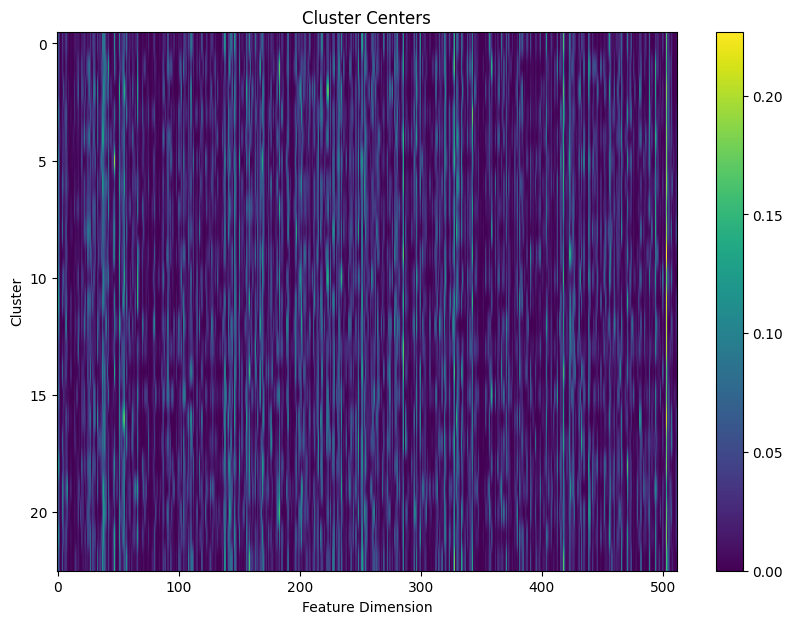

In [37]:
# Combine all embeddings into one array
# all_embeddings = np.concatenate([reshaped_emb, reshaped_emb2, reshaped_emb3])
print(f"Combined shape: {reshaped_emb.shape}")  # This should be (167188, 512)

# Number of clusters
num_clusters = unique_labels

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reshaped_emb)

# Get cluster labels
cluster_labels = kmeans.labels_
print(f"Cluster labels shape: {cluster_labels.shape}")  
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")  # This should be (10, 512)
# Optionally, visualize the cluster centers
plt.figure(figsize=(10, 7))
plt.imshow(kmeans.cluster_centers_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Cluster Centers')
plt.xlabel('Feature Dimension')
plt.ylabel('Cluster')
plt.show()

# Save cluster labels if needed
np.save('cluster_labels.npy', cluster_labels)

In [32]:
# Assuming you have combined_embeddings and cluster_labels from the previous steps

def calculate_cluster_statistics(embeddings, labels):
    unique_labels = np.unique(labels)
    
    cluster_ids = np.array(unique_labels)
    num_images_list = np.array([np.sum(labels == label) for label in unique_labels])
    mean_features_list = np.array([np.mean(embeddings[labels == label], axis=0) for label in unique_labels])
    std_features_list = np.array([np.std(embeddings[labels == label], axis=0) for label in unique_labels])
    
    return cluster_ids, num_images_list, mean_features_list, std_features_list

# Calculate the cluster statistics
cluster_ids, num_images_list, mean_features_list, std_features_list = calculate_cluster_statistics(reshaped_emb, cluster_labels)


image_num_recheck = np.sum(num_images_list)
# Print the first few elements of each array for inspection
print("Cluster IDs:", cluster_ids)
print("Number of Images:", num_images_list)
print("Total number of images:", image_num_recheck)





Cluster IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Number of Images: [ 278  350  912  642  643  459  419  272  292 1005  550  688  259  374
  298  573  107  278  276  489  292  490  508]
Total number of images: 10454


In [33]:

def calculate_cluster_statistics(embeddings, labels):
    unique_labels = np.unique(labels)
    statistics = {}
    
    for label in unique_labels:
        cluster_embeddings = embeddings[labels == label]
        statistics[label] = {
            'num_images': len(cluster_embeddings),
            'mean_feature': np.mean(cluster_embeddings, axis=0),
            'std_feature': np.std(cluster_embeddings, axis=0)
        }
    
    return statistics

cluster_statistics = calculate_cluster_statistics(reshaped_emb, cluster_labels)

# Print cluster statistics
for cluster_id, stats in cluster_statistics.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Number of Images: {stats['num_images']}")
    print(f"  Mean Feature Vector: {stats['mean_feature'][:5]}...")  # Print first 5 elements for brevity
    print(f"  Standard Deviation of Feature Vector: {stats['std_feature'][:5]}...")  # Print first 5 elements for brevity


Cluster 0:
  Number of Images: 278
  Mean Feature Vector: [8.323713e-43 0.000000e+00 0.000000e+00 4.152392e-02 0.000000e+00]...
  Standard Deviation of Feature Vector: [0.         0.         0.         0.00296346 0.        ]...
Cluster 1:
  Number of Images: 350
  Mean Feature Vector: [8.295687e-43 0.000000e+00 0.000000e+00 4.687455e-02 0.000000e+00]...
  Standard Deviation of Feature Vector: [0.         0.         0.         0.00042313 0.        ]...
Cluster 2:
  Number of Images: 912
  Mean Feature Vector: [8.3237129e-43 0.0000000e+00 0.0000000e+00 4.1139193e-02 0.0000000e+00]...
  Standard Deviation of Feature Vector: [0.         0.         0.         0.00113586 0.        ]...
Cluster 3:
  Number of Images: 642
  Mean Feature Vector: [8.3237129e-43 0.0000000e+00 0.0000000e+00 4.0529173e-02 0.0000000e+00]...
  Standard Deviation of Feature Vector: [0.         0.         0.         0.00236147 0.        ]...
Cluster 4:
  Number of Images: 643
  Mean Feature Vector: [8.3377259e-43 0.000

In [34]:
# Load the cluster labels
cluster_labels = np.load('cluster_labels.npy')
# print (cluster_labels.shape)
print (cluster_labels)
print(unique_labels)
# second_column.shape

[ 6  7 20 ...  5 10  9]
[ 2.  3. 12. ... 19. 21. 22.]


In [42]:
feature_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/runs/reid/inference/selfmodel30/camera_0003.npy'
groundtruth_path = 'C:/Users/pt101/Desktop/EE-443-husky-team-spr24-master/data/train/camera_0003.txt'

############################################ Cluster Number based on groundtruth  ############################################ 

# Read the file and load the content into a numpy array
data = np.loadtxt(groundtruth_path, delimiter=',')
# Print the numpy array
print(data[0][2])
# Extract the second column (index 1)
second_column = data[:, 1]
# Find unique numbers in the second column
unique_numbers = np.unique(second_column)
# Count the number of unique numbers
unique_count = len(unique_numbers)
# Print the results
print("Unique numbers in the second column:", unique_numbers)
print("Number of cluster:", unique_count)


############################################ Cluster Label  ############################################ 
# Load the numpy files
emb_save_path = feature_path
emb = np.load(emb_save_path, allow_pickle=True)

# reshaped_emb = np.stack(emb)
print(reshaped_emb.shape)  

print(f"Combined shape: {reshaped_emb.shape}")  # This should be (167188, 512)

# Number of clusters
num_clusters = unique_count  # You can choose the number of clusters based on your requirements

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reshaped_emb)

# Get cluster labels
cluster_labels = kmeans.labels_

############################################ Cluster Label from doing  ############################################ 

# Extract the PID (person ID) from ground truth
ground_truth_pids = second_column.astype(int)

# Compute the confusion matrix
confusion = confusion_matrix(ground_truth_pids, cluster_labels)

# Use the Hungarian algorithm to find the best matching
row_ind, col_ind = linear_sum_assignment(-confusion)

# Create a new mapping based on the best matching
new_cluster_labels = np.zeros_like(cluster_labels)
for i, j in zip(row_ind, col_ind):
    new_cluster_labels[cluster_labels == j] = i

# Evaluate the alignment quality
accuracy = np.mean(new_cluster_labels == ground_truth_pids)
print(f"Alignment accuracy: {accuracy:.4f}")

# Optionally, compute other metrics (precision, recall, F1 score)


precision = precision_score(ground_truth_pids, new_cluster_labels, average='weighted')
recall = recall_score(ground_truth_pids, new_cluster_labels, average='weighted')
f1 = f1_score(ground_truth_pids, new_cluster_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


0.0
Unique numbers in the second column: [ 0.  1.  2.  3.  4.  5.  7.  8.  9. 10. 11. 12. 13. 15. 16. 17. 18. 19.
 20. 21. 22. 23.]
Number of cluster: 22
(10454, 512)
Combined shape: (10454, 512)
Alignment accuracy: 0.4019
Precision: 0.5202
Recall: 0.4019
F1 Score: 0.4274


c:\Users\pt101\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pt101\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
